# ResNet

In [1]:
# please upload data directory to Google drive
# use Google Drive to load data
from google.colab import drive, files
import zipfile

drive.mount('/content/drive')
zipname = 'supports.zip'
uploaded = files.upload()
# Extract the zip file
with zipfile.ZipFile(zipname, 'r') as zip_ref:
  zip_ref.extractall()  # Extract all files to the current directory

Mounted at /content/drive


Saving supports.zip to supports.zip


In [2]:
!pip install -r "./requirements.txt"
!pip install torchinfo
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.9/171.9 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.0/812.0 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [3]:
from torch.nn import (Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d,
                      Linear, AdaptiveAvgPool2d, BatchNorm1d, Sigmoid, Dropout)
import torch
from sklearn.model_selection import train_test_split
import os
import librosa
import numpy as np
from torchinfo import summary
from torch import nn
from torch.optim import Adam
from torcheval.metrics import MulticlassAUROC, MulticlassF1Score
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Util Methods

In [4]:
# Util
def create_dataloader(x, y, batch_size=64, cuda=False):
    if cuda:
        x = torch.tensor(x, dtype=torch.float).cuda()
        y = torch.tensor(y, dtype=torch.long).cuda()
    else:
        x = torch.tensor(x, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.long)
    data = TensorDataset(x, y)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    return dataloader


def k_fold_cross_validation(x, y, k):
    fold_size = x.shape[0] // k
    xs_train = []
    ys_train = []
    xs_valid = []
    ys_valid = []
    for i in range(k - 1):
        xs_valid.append(x[fold_size * i:fold_size * (i + 1)])
        ys_valid.append(y[fold_size * i:fold_size * (i + 1)])
        xs_train.append(np.concatenate([x[:fold_size * i], x[fold_size * (i + 1):]], axis=0))
        ys_train.append(np.concatenate([y[:fold_size * i], y[fold_size * (i + 1):]], axis=0))
    xs_valid.append(x[fold_size * (k - 1):])
    ys_valid.append(y[fold_size * (k - 1):])
    xs_train.append(x[:fold_size * (k - 1)])
    ys_train.append(y[:fold_size * (k - 1)])
    return xs_train, ys_train, xs_valid, ys_valid

def train(model, loss_function, opt, dataloaders_train, dataloaders_valid, k, epoch=10):
    epochs_loss = []
    epochs_accuracy = []
    for i in range(epoch):
        print("-------epoch  {} -------".format(i + 1))
        epoch_loss = 0
        epoch_accuracy = 0

        for j in range(k):
            print(f'fold {j + 1}:')

            # train
            loss_train = 0
            accuracy_train = 0
            train_size = 0
            for batch_idx, (data, target) in enumerate(dataloaders_train[j]):
                data = data.cuda()
                target = target.cuda()
                model.train()
                output = model(data)
                loss = loss_function(output, target)
                opt.zero_grad()
                loss.backward()
                opt.step()
                data_size = len(data)
                loss_train += loss.item() * data_size
                accuracy_train += (output.argmax(1) == target).sum()
                train_size += data_size
            print("train set loss: {}".format(loss_train / train_size))
            print("train set accuracy: {}".format(accuracy_train / train_size))

            # valid
            loss_valid = 0
            accuracy_valid = 0
            valid_size = 0
            for batch_idx, (data, target) in enumerate(dataloaders_valid[j]):
                data = data.cuda()
                target = target.cuda()
                model.eval()
                with torch.no_grad():
                    output = model(data)
                    loss = loss_function(output, target)
                    data_size = len(data)
                    loss_valid += loss.item() * data_size
                    accuracy_valid += (output.argmax(1) == target).sum()
                    valid_size += data_size
            print("valid set loss: {}".format(loss_valid / valid_size))
            print("valid set accuracy: {}".format(accuracy_valid / valid_size))
            epoch_loss += loss_valid / valid_size
            epoch_accuracy += accuracy_valid / valid_size
        epoch_loss = round(epoch_loss / k, 3)
        epoch_accuracy = round(float(epoch_accuracy) / k, 3)
        print(f"epoch loss: {epoch_loss}")
        print(f"epoch accuracy: {epoch_accuracy}")
        epochs_loss.append(epoch_loss)
        epochs_accuracy.append(epoch_accuracy)
    return {"loss": epochs_loss, "accuracy": epochs_accuracy}


def test(model, loss_function, dataloader_test):
    loss_test = 0
    accuracy_test = 0
    AUC_test = 0
    f1_score_test = 0
    test_size = 0
    for batch_idx, (data, target) in enumerate(dataloader_test):
        data = data.cuda()
        target = target.cuda()
        model.eval()
        with torch.no_grad():
            output = model(data)
            loss = loss_function(output, target)
            loss_test += loss.item() * len(data)
            accuracy_test += (output.argmax(1) == target).sum()
            test_size += len(data)
            auc = MulticlassAUROC(num_classes=10)
            auc.update(output, target)
            AUC_test += auc.compute() * len(data)
            auc.reset()
            f1 = MulticlassF1Score(num_classes=10)
            f1.update(output, target)
            f1_score_test += f1.compute() * len(data)
            f1.reset()
    loss = round(loss_test / test_size, 3)
    accuracy = round(float(accuracy_test) / test_size,3)
    AUC = round(float(AUC_test) / test_size, 3)
    f1 = round(float(f1_score_test) / test_size,3)
    print(f"test set loss: {loss}")
    print(f"test set accuracy: {accuracy}")
    print(f"test set AUC: {AUC}")
    print(f"test set f1-score: {f1}")
    return loss, accuracy, AUC, f1

# Read Data

In [6]:
root = '/content/drive/MyDrive/Data/genres_original' # Change according path storing data
genres = os.listdir(root)
x = []
y = []
length = []
sr = 16*1000
for genre in genres:
    genre_root = os.path.join(root, genre)
    audios = os.listdir(genre_root)
    for audio in audios:
        audio_path = os.path.join(genre_root, audio)
        signal, sr = librosa.load(audio_path, sr=sr)
        x.append(signal)
        length.append(len(signal))
        y.append(genres.index(genre))
min_length = min(length)
print("Finsh reading data")

Finsh reading data


# Conversion, Compression and Normalisation

In [7]:
top_db = 80
for i in range(len(x)):
    signal = x[i][:min_length]
    mel_spect = librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=1024) # convert signals to mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max, top_db=top_db) # log compression
    x[i] = mel_spect/-top_db # normalisation
print("finish conversion and compression")

finish conversion and compression


# Split Data

In [8]:
x = np.asarray(x)
x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
y = np.asarray(y)
print(x.shape)

(1000, 1, 128, 936)


In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=y,shuffle=True)
# k-fold cross validation
k = 5
xs_train, ys_train, xs_valid, ys_valid = k_fold_cross_validation(x_train,y_train,k)
print("finish splitting data")

finish splitting data


# Create Dataloaders

In [35]:
batch_size = 64
dataloaders_train = []
dataloaders_valid = []
for i in range(k):
    dataloaders_train.append(create_dataloader(xs_train[i], ys_train[i], batch_size=batch_size))
    dataloaders_valid.append(create_dataloader(xs_valid[i], ys_valid[i], batch_size=batch_size))
dataloader_test = create_dataloader(x_test, y_test, batch_size=batch_size)
print("finish creating dataloaders")

finish creating dataloaders


# ResNet Model

In [13]:
class ResNet(Module):
    def __init__(self, class_num, pre_filter_size=3, in_channels=1):
        super(ResNet, self).__init__()

        # preprocessing layer
        self.pl = Sequential(
            Conv2d(in_channels, 64, kernel_size=pre_filter_size, stride=2, padding=1),
            BatchNorm2d(64),
            ReLU(),
            MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
        )

        # Residual Blocks
        self.block1 = ResidualBlock(64, 64)
        self.block2 = ResidualBlock(64, 64)
        self.block3 = ResidualBlock(64, 128, 2)
        self.block4 = ResidualBlock(128, 128)
        self.block5 = ResidualBlock(128, 256, 2)
        self.block6 = ResidualBlock(256, 256)
        self.block7 = ResidualBlock(256, 512, 2)
        self.block8 = ResidualBlock(512, 512)

        self.avg_pool = AdaptiveAvgPool2d((1, 1))
        self.fc = Sequential(Linear(512, class_num),
                             BatchNorm1d(class_num),
                             Sigmoid())

    def forward(self, x):
        o = self.pl(x)
        o = self.block1(o)
        o = self.block2(o)
        o = self.block3(o)
        o = self.block4(o)
        o = self.block5(o)
        o = self.block6(o)
        o = self.block7(o)
        o = self.block8(o)
        o = self.avg_pool(o)
        o = o.view(o.size(0), -1)
        o = self.fc(o)
        return o


class ResidualBlock(Module):
    def __init__(self, in_filters, out_filters, strides=1, dropout=False):
        super().__init__()

        self.cl1 = Conv2d(in_filters, out_filters, kernel_size=3, stride=strides, padding=1)
        self.bn1 = BatchNorm2d(out_filters)
        self.relu1 = ReLU()

        self.cl2 = Conv2d(out_filters, out_filters, kernel_size=3, stride=1, padding=1)
        self.bn2 = BatchNorm2d(out_filters)

        if strides != 1:
            self.shortcut = Sequential(Conv2d(in_filters, out_filters, kernel_size=(1, 1), stride=strides),
                                       BatchNorm2d(out_filters))
        else:
            self.shortcut = lambda x: x
        self.relu2 = ReLU()
        self.dropout = dropout
        if dropout:
            self.dp = Dropout(0.5)

    def forward(self, x):
        o = self.cl1(x)
        o = self.bn1(o)
        o = self.relu1(o)
        o = self.cl2(o)
        o = self.bn2(o)
        o = o + self.shortcut(x)
        o = self.relu2(o)
        if self.dropout:
            o = self.dp(o)
        return o


# Model Construction

In [36]:
model = ResNet(10,pre_filter_size=3,in_channels=1)
model.cuda()
loss_function = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=0.001)
summary(model,[(batch_size,1,x.shape[2],x.shape[3])])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 10]                  --
├─Sequential: 1-1                        [64, 64, 32, 234]         --
│    └─Conv2d: 2-1                       [64, 64, 64, 468]         640
│    └─BatchNorm2d: 2-2                  [64, 64, 64, 468]         128
│    └─ReLU: 2-3                         [64, 64, 64, 468]         --
│    └─MaxPool2d: 2-4                    [64, 64, 32, 234]         --
├─ResidualBlock: 1-2                     [64, 64, 32, 234]         --
│    └─Conv2d: 2-5                       [64, 64, 32, 234]         36,928
│    └─BatchNorm2d: 2-6                  [64, 64, 32, 234]         128
│    └─ReLU: 2-7                         [64, 64, 32, 234]         --
│    └─Conv2d: 2-8                       [64, 64, 32, 234]         36,928
│    └─BatchNorm2d: 2-9                  [64, 64, 32, 234]         128
│    └─ReLU: 2-10                        [64, 64, 32, 234]         --
├─R

# Train

In [37]:
epoch = 10
history = train(model,loss_function,opt,dataloaders_train,dataloaders_valid,k,epoch=epoch)
print("finish training")

-------epoch  1 -------
fold 1:
train set loss: 2.1554014921188354
train set accuracy: 0.34375
valid set loss: 2.262912082672119
valid set accuracy: 0.17499999701976776
fold 2:
train set loss: 2.0677494287490843
train set accuracy: 0.4765625
valid set loss: 2.330095386505127
valid set accuracy: 0.11874999850988388
fold 3:
train set loss: 2.0357067584991455
train set accuracy: 0.5625
valid set loss: 2.2932223320007323
valid set accuracy: 0.25
fold 4:
train set loss: 1.9993702173233032
train set accuracy: 0.6078125238418579
valid set loss: 2.337504196166992
valid set accuracy: 0.14374999701976776
fold 5:
train set loss: 1.9939122676849366
train set accuracy: 0.6109375357627869
valid set loss: 2.2610467433929444
valid set accuracy: 0.20000000298023224
epoch loss: 2.297
epoch accuracy: 0.177
-------epoch  2 -------
fold 1:
train set loss: 1.9763256549835204
train set accuracy: 0.6500000357627869
valid set loss: 2.2065785408020018
valid set accuracy: 0.20624999701976776
fold 2:
train set lo

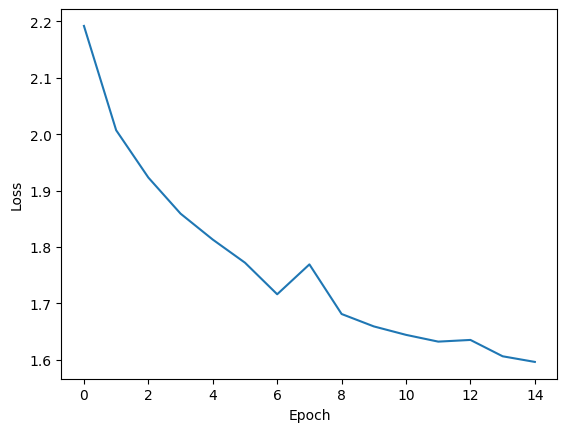

In [32]:
plt.plot(range(epoch),history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

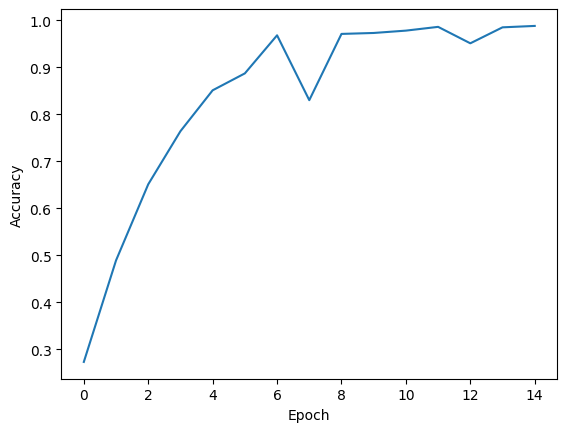

In [33]:
plt.plot(range(epoch), history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test

In [34]:
loss, acc, AUC, f1 = test(model,loss_function,dataloader_test)

test set loss: 1.774
test set accuracy: 0.765
test set AUC: 0.958
test set f1-score: 0.765
